 <p style = "font-size: 35px;font-weight: ;text-align:center;color:#800000"> Clean Dishes vs Ecosure Violations: <b>Key Driver Analysis</b> </p>

<div>
    <img src = "http://upload.wikimedia.org/wikipedia/en/0/0c/Mu_Sigma_Logo.jpg" align="left" style="height:100px;margin-right:100px">
</div>
<div>
    <img src = "https://upload.wikimedia.org/wikipedia/commons/2/26/Ecolab.svg" align="right" style="height:40px;margin-left:100px; margin-top:25px">
</div>

<p style="font-size:100%;text-align:left;font-weight:bold"> Created by  : Mu Sigma team for Ecolab
<p style="font-size:100%;text-align:left;font-weight:bold;"> Last edited : 05/13/2021

 <p style = "font-size: 20px;font-weight: bold;text-align: left;color:#000000"> Description:   </p>
 
This notebook is used to explore the relationship between the drivers and measures to get . Here, we are comparing, driver Dishwash data (no of successful/ without alarm racks runs) Clean Dishes with measure Ecosure violations (Total no of violations per audit & Mean Audit Scores).<br>

Data Used: <br>
* For <b>Dishwash Machine </b>, across different brands
* For <b>Ecosure Audit Data</b>, across different brands

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import json
import pickle 
import pandas as pd
import numpy as np
import warnings
import itertools
import datetime
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy import stats
import matplotlib
import seaborn as sns
import pytz
import pyodbc
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
utc=pytz.UTC
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 2000)
pd.options.display.float_format = '{:.4f}'.format

In [3]:
######################################################### Audit Data ###################################################################
########################################################################################################################################

df_audit = pd.read_csv('./csv/EcosureAudits80.csv')

# Aggregating data at month year level
df_audit['AuditStarted'] = pd.to_datetime(df_audit['AuditStarted'], errors='coerce')
df_audit['Date'] = df_audit['AuditStarted'].dt.date
df_audit['month_year'] = df_audit['Date'].apply(lambda x: x.strftime('%B-%Y'))

df_violations = df_audit.groupby(['month_year', 'ClientName'], as_index=False).agg({'Level1_Violations' : 'sum', 'Level2_Violations' : 'sum',
                                                                                    'Level3_Violations' : 'sum', 'Score' : 'mean', 
                                                                                    'ClientID' : 'count'})

# Renaming Columns
df_violations.rename({'Level1_Violations' : 'Minor_Violations', 
                      'Level2_Violations' : 'Major_Violations',
                      'Level3_Violations' : 'Critical_Violations',
                      'Score' : 'Mean_Audit_Score',
                      'ClientName' : 'Brand',
                      'ClientID' : 'No_of_Audits'},axis=1, inplace=True)

# Adding KPIs
df_violations['Total_No_of_Violations'] = df_violations['Minor_Violations'] + df_violations['Major_Violations'] + df_violations['Critical_Violations']

# Adding Normalized KPIs
df_violations['Minor_Violations_per_audit'] = df_violations['Minor_Violations']/df_violations['No_of_Audits']
df_violations['Major_Violations_per_audit'] = df_violations['Major_Violations']/df_violations['No_of_Audits']
df_violations['Critical_Violations_per_audit'] = df_violations['Critical_Violations']/df_violations['No_of_Audits']
df_violations['Total_No_of_Violations_per_audit'] = df_violations['Total_No_of_Violations']/df_violations['No_of_Audits']

# Ordering by month
new_orders = ['September-2016', 'October-2016',  'November-2016', 'December-2016', 'January-2017', 'February-2017', 'March-2017', 'April-2017',
              'May-2017', 'June-2017', 'July-2017', 'August-2017', 'September-2017', 'October-2017', 'November-2017', 'December-2017',
              'January-2018', 'February-2018','March-2018','April-2018', 'May-2018', 'June-2018', 'July-2018', 'August-2018', 'September-2018',
              'October-2018', 'November-2018', 'December-2018', 'January-2019', 'February-2019', 'March-2019', 'April-2019', 
              'May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020','January-2021', 'February-2021', 'March-2021', 'April-2021']

df_violations['month_year'] = pd.Categorical(df_violations['month_year'], categories=new_orders, ordered=True)
df_violations.sort_values(by=['month_year'], ascending=True, inplace=True)
df_violations = df_violations[df_violations.month_year.notnull()]

In [4]:
print("Total No of unique brands present in Ecosure data:", df_audit.ClientName.nunique())
print('\n \n')
print("Name's of the brands used for analysis:", df_audit.ClientName.unique())

Total No of unique brands present in Ecosure data: 20

 

Name's of the brands used for analysis: ['Panera' 'IHOP' 'Buffalo Wild Wings' 'Noodles & Co.'
 "Famous Dave's of America,  Inc." 'True Food Kitchen' 'Twin Peaks'
 'Benihana National Corp' 'On the Border' "Applebee's" 'Texas Roadhouse'
 "Friendly's" 'Margaritaville' 'Cafe Zupas' 'Ruby Tuesday Inc.' 'WingStop'
 'Four Corners Tavern Group' 'Modern Market' 'Wood Ranch'
 "O'Charley's, Inc."]


In [5]:
################################################## Dishwash Machine Data ###################################################################
############################################################################################################################################

df_dishwash = pd.read_csv('/User/csv/DishwashMachine.csv')
df_dishwash.head()

,DeviceId,AccountNumber,AccountName,PeriodAxisOrig,deviceID1,DateID,SanitizerOOP_Sum,DetergentOOP_Sum,RinseAidOOP_Sum,LowRinseTemp_Sum,LowWashTemp_Sum,WashTankChangeOut_Sum,ProbeMode_Sum,TimedMode_Sum,RackShortCycled_Sum,DetergentLidSwitch_Sum,RinseAidLidSwitch_Sum,ThirdProductLidSwitch_Sum,RackCount
0,ApexTSC-D1909F132745,503548951,EPICERIE,00:00.0,ApexTSC-D1909F132745,2020422,1,0,0,43,39,nan,nan,nan,nan,nan,nan,nan,48
1,ApexTSC-D1830F107688,504084099,NUPA,00:00.0,ApexTSC-D1830F107688,2020422,0,1,0,0,0,nan,nan,nan,nan,nan,nan,nan,20
2,ApexTSC-D1829F107575,503548661,HILLS MARKET DOWNTOWN,00:00.0,ApexTSC-D1829F107575,2020422,0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,53
3,ApexTSC-D1838F116014,504000937,PLAYA CANCUN,00:00.0,ApexTSC-D1838F116014,2020422,0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,41
4,ApexTSC-D1738F090604,502627906,CACTUS CLUB,00:00.0,ApexTSC-D1738F090604,2020422,0,2,0,0,2,nan,nan,nan,nan,nan,nan,nan,178


In [6]:
# fuzzy match to get all the account names for which ecosure data is present

from itertools import product
from fuzzywuzzy import fuzz

def get_fuzz_score(str1, str2):
    partial_ratio = fuzz.partial_ratio(str1, str2)
    return partial_ratio

matching_list = []

a = ['Panera', 'IHOP', 'Buffalo Wild Wings', 'Noodles & Co.', "Famous Dave's,  Inc.", 'True Food Kitchen', 'Twin Peaks',
     'Benihana National Corp', 'On the Border', "Applebee's", 'Texas Roadhouse', "Friendly's", 'Margaritaville', 'Cafe Zupas', 'Ruby Tuesday Inc.',
     'WingStop', 'Four Corners Tavern Group', 'Mod Market', 'Wood Ranch', "O Charleys"]

a = [item.upper() for item in a]

b = list(df_dishwash.AccountName.unique())

for first, second in product(a, b):
    if get_fuzz_score(first, second) > 80:
        matching_list.append(second)

In [7]:
print(matching_list)

['PANGEA', 'BANDERA RESTAURANT 808', 'BANDERA REST 801', 'LA CANTERA HILL CNTRY RESRT', 'PANERA BREAD 3483', 'PANERA BREAD 4646', 'SUGARCANE RAW BAR & GRILL', 'PANERA BREAD 4154', 'IHOP 1651', 'IHOP 1609', 'IHOP ORLANDO 36225', 'IHOP 3368', 'IHOP 1750', 'IHOP 3695', 'BUFFALO WILD WINGS 3311', 'BUFFALO WILD WINGS 3492', 'BUFFALO WILD WINGS 3704', 'BUFFALO WILD WINGS 3259', 'BUFFALO WILD WINGS 3750', 'NOODLES & COMPANY 9503', 'NOODLES & COMPANY 682', 'NOODLES & COMPANY 417', 'NOODLES & COMPANY 812', 'NOODLES & COMPANY 8018', 'NOODLES & COMPANY 762', 'NOODLES & COMPANY 212', 'NOODLES & COMPANY 228', 'NOODLES & COMPANY 517', 'NOODLES & COMPANY 733', 'NOODLES & COMPANY 584', 'NOODLES & COMPANY 8202', 'NOODLES & COMPANY 150', 'NOODLES & COMPANY 249', 'NOODLES & COMPANY 119', 'NOODLES & CO 8013', 'NOODLES & COMPANY 203', 'NOODLES & COMPANY 685', 'NOODLES & COMPANY 206', 'NOODLES & COMPANY 402', 'NOODLES & COMPANY 754', 'NOODLES & COMPANY 760', 'NOODLES & COMPANY 627', 'NOODLES & COMPANY 815',

In [8]:
# filtered account list based on fuzzy matching for brands in Ecosure data

accounts_list = ['PANERA BREAD 3483', 'PANERA BREAD 4646', 'PANERA BREAD 4154', 'IHOP 1651', 'IHOP 1609', 'IHOP ORLANDO 36225', 'IHOP 3368', 'IHOP 1750',
                 'IHOP 3695', 'BUFFALO WILD WINGS 3311', 'BUFFALO WILD WINGS 3492', 'BUFFALO WILD WINGS 3704', 'BUFFALO WILD WINGS 3259', 'BUFFALO WILD WINGS 3750', 
                 'NOODLES & COMPANY 9503', 'NOODLES & COMPANY 682', 'NOODLES & COMPANY 417', 'NOODLES & COMPANY 812', 'NOODLES & COMPANY 8018', 
                 'NOODLES & COMPANY 762', 'NOODLES & COMPANY 212', 'NOODLES & COMPANY 228', 'NOODLES & COMPANY 517', 'NOODLES & COMPANY 733', 
                 'NOODLES & COMPANY 584', 'NOODLES & COMPANY 8202', 'NOODLES & COMPANY 150', 'NOODLES & COMPANY 249', 'NOODLES & COMPANY 119', 
                 'NOODLES & CO 8013', 'NOODLES & COMPANY 203', 'NOODLES & COMPANY 685', 'NOODLES & COMPANY 206', 'NOODLES & COMPANY 402', 
                 'NOODLES & COMPANY 754', 'NOODLES & COMPANY 760', 'NOODLES & COMPANY 627', 'NOODLES & COMPANY 815', 'NOODLES & COMPANY 7105',
                 'NOODLES & COMPANY 210', 'NOODLES & COMPANY 135', 'NOODLES & COMPANY 610', 'NOODLES & COMPANY 304', 'NOODLES & COMPANY 516', 
                 'NOODLES & CO 8022', 'NOODLES & COMPANY 468', 'NOODLES & COMPANY 869', 'NODDLES & COMPANY 7201', 'NOODLES & COMPANY 9504', 
                 'NOODLES & COMPANY 705', 'NOODLES & COMPANY 615', 'NOODLES & COMPANY 822', 'NOODLES & COMPANY 171', 'NOODLES & COMPANY 770',
                 'NOODLES & COMPANY 345', 'TRUE FOOD KITCHEN', 'TWIN PEAKS', 'TWIN PEAKS 0045', 'TWIN PEAKS GREENVILLE', 
                 'BENIHANAS', 'BENIHANA', 'APPLEBEES 721', 'APPLEBEES 90001', 'APPLEBEES 8829', 'APPLEBEES 9733', 'APPLEBEES 210', 'APPLEBEES 9270',
                 'APPLEBEES', 'APPLEBEES 99031', 'APPLEBEES 86046', 'APPLEBEES 079003', 'APPLEBEES 8943', 'APPLEBEES 216', 'APPLEBEES 99098', 
                 'APPLEBEES 079031', 'APPLEBEES 9324', 'APPLEBEES 202', 'APPLEBEES 99068', 'TEXAS ROAD HOUSE 151', 'TEXAS ROAD HOUSE 533', 'TEXAS ROADHOUSE 26', 
                 'TEXAS ROADHOUSE 595', 'TEXAS ROAD HOUSE 317', 'TEXAS ROADHOUSE 351', 'TEXAS ROADHOUSE 142', 'TEXAS ROAD HOUSE 217',
                 'TEXAS ROAD HOUSE 308', 'TEXAS ROAD HOUSE 109', 'TEXAS ROADHOUSE 706 FILTER', 'TEXAS ROADHOUSE 601', 'MARGARITAVILLE LAKE RESORT, KITCHEN',
                 'MARGARITAVILLE CAFE', 'AIR MARGARITAVILLE', 'MARGARITAVILLE 911743', 'CAFE ZUPAS SCHAUMBURG 143', 'CAFE ZUPAS CAMELBACK 115',
                 'CAFE ZUPAS COTTONWOOD 104', 'CAFE ZUPAS 002', 'CAFE ZUPAS LAS VEGAS 48', 'WINGSTOP 627', 'WING STOP 1178', 'MODMARKET 001',
                 'MODMARKET 012', 'MODMARKET 13', 'MODMARKET 18', 'MODMARKET 025', 'OCHARLEYS', 'OCHARLEYS 356', 'OCHARLEYS 342', 'OCHARLEYS 216',
                 'OCHARLEYS 343', 'OCHARLEYS 210', 'OCHARLEYS 310', 'OCHARLEYS 370', 'O CHARLEYS 334', 'OCHARLEYS 265',
                 'OCHARLEYS 309', 'OCHARLEYS 261']

df_dishwash_filtered = df_dishwash[df_dishwash.AccountName.isin(accounts_list)]

In [9]:
# create brand level mapping for filtered data set (map each account back to it's brand

dict_brand_mappin = {
 'PANERA BREAD 3483' : 'Panera',
 'PANERA BREAD 4646' : 'Panera',
 'PANERA BREAD 4154' : 'Panera',
 'IHOP 1651' : 'IHOP',
 'IHOP 1609' : 'IHOP',
 'IHOP ORLANDO 36225' : 'IHOP',
 'IHOP 3368' : 'IHOP',
 'IHOP 1750' : 'IHOP',
 'IHOP 3695' : 'IHOP',
 'BUFFALO WILD WINGS 3311' : 'Buffalo Wild Wings',
 'BUFFALO WILD WINGS 3492' : 'Buffalo Wild Wings',
 'BUFFALO WILD WINGS 3704' : 'Buffalo Wild Wings',
 'BUFFALO WILD WINGS 3259' : 'Buffalo Wild Wings',
 'BUFFALO WILD WINGS 3750' : 'Buffalo Wild Wings',
 'NOODLES & COMPANY 9503' : 'Noodles & Co.',
 'NOODLES & COMPANY 682' : 'Noodles & Co.',
 'NOODLES & COMPANY 417' : 'Noodles & Co.',
 'NOODLES & COMPANY 812' : 'Noodles & Co.',
 'NOODLES & COMPANY 8018' : 'Noodles & Co.',
 'NOODLES & COMPANY 762' : 'Noodles & Co.',
 'NOODLES & COMPANY 212' : 'Noodles & Co.',
 'NOODLES & COMPANY 228' : 'Noodles & Co.',
 'NOODLES & COMPANY 517' : 'Noodles & Co.',
 'NOODLES & COMPANY 733' : 'Noodles & Co.',
 'NOODLES & COMPANY 584' : 'Noodles & Co.',
 'NOODLES & COMPANY 8202' : 'Noodles & Co.',
 'NOODLES & COMPANY 150' : 'Noodles & Co.',
 'NOODLES & COMPANY 249' : 'Noodles & Co.',
 'NOODLES & COMPANY 119' : 'Noodles & Co.',
 'NOODLES & CO 8013' : 'Noodles & Co.',
 'NOODLES & COMPANY 203' : 'Noodles & Co.',
 'NOODLES & COMPANY 685' : 'Noodles & Co.',
 'NOODLES & COMPANY 206' : 'Noodles & Co.',
 'NOODLES & COMPANY 402' : 'Noodles & Co.',
 'NOODLES & COMPANY 754' : 'Noodles & Co.',
 'NOODLES & COMPANY 760' : 'Noodles & Co.',
 'NOODLES & COMPANY 627' : 'Noodles & Co.',
 'NOODLES & COMPANY 815' : 'Noodles & Co.',
 'NOODLES & COMPANY 7105' : 'Noodles & Co.',
 'NOODLES & COMPANY 210' : 'Noodles & Co.',
 'NOODLES & COMPANY 135' : 'Noodles & Co.',
 'NOODLES & COMPANY 610' : 'Noodles & Co.',
 'NOODLES & COMPANY 304' : 'Noodles & Co.',
 'NOODLES & COMPANY 516' : 'Noodles & Co.',
 'NOODLES & CO 8022' : 'Noodles & Co.',
 'NOODLES & COMPANY 468' : 'Noodles & Co.',
 'NOODLES & COMPANY 869' : 'Noodles & Co.',
 'NODDLES & COMPANY 7201' : 'Noodles & Co.',
 'NOODLES & COMPANY 9504' : 'Noodles & Co.',
 'NOODLES & COMPANY 705' : 'Noodles & Co.',
 'NOODLES & COMPANY 615' : 'Noodles & Co.',
 'NOODLES & COMPANY 822' : 'Noodles & Co.',
 'NOODLES & COMPANY 171' : 'Noodles & Co.',
 'NOODLES & COMPANY 770' : 'Noodles & Co.',
 'NOODLES & COMPANY 345' : 'Noodles & Co.',
 'TRUE FOOD KITCHEN' : 'True Food Kitchen',
 'TWIN PEAKS' : 'Twin Peaks',
 'TWIN PEAKS 0045' : 'Twin Peaks',
 'TWIN PEAKS GREENVILLE' : 'Twin Peaks',
 'BENIHANAS' : 'Benihana National Corp',
 'BENIHANA' : 'Benihana National Corp',
 'APPLEBEES 721' : "Applebee's",
 'APPLEBEES 90001' : "Applebee's",
 'APPLEBEES 8829' : "Applebee's",
 'APPLEBEES 9733' : "Applebee's",
 'APPLEBEES 210' : "Applebee's",
 'APPLEBEES 9270' : "Applebee's",
 'APPLEBEES' : "Applebee's",
 'APPLEBEES 99031' : "Applebee's",
 'APPLEBEES 86046' : "Applebee's",
 'APPLEBEES 079003' : "Applebee's",
 'APPLEBEES 8943' : "Applebee's",
 'APPLEBEES 216' : "Applebee's",
 'APPLEBEES 99098' : "Applebee's",
 'APPLEBEES 079031' : "Applebee's",
 'APPLEBEES 9324' : "Applebee's",
 'APPLEBEES 202' : "Applebee's",
 'APPLEBEES 99068' : "Applebee's",
 'TEXAS ROAD HOUSE 151' : 'Texas Roadhouse',
 'TEXAS ROAD HOUSE 533' : 'Texas Roadhouse',
 'TEXAS ROADHOUSE 26' : 'Texas Roadhouse',
 'TEXAS ROADHOUSE 595' : 'Texas Roadhouse',
 'TEXAS ROAD HOUSE 317' : 'Texas Roadhouse',
 'TEXAS ROADHOUSE 351' : 'Texas Roadhouse',
 'TEXAS ROADHOUSE 142' : 'Texas Roadhouse',
 'TEXAS ROAD HOUSE 217' : 'Texas Roadhouse',
 'TEXAS ROAD HOUSE 308' : 'Texas Roadhouse',
 'TEXAS ROAD HOUSE 109' : 'Texas Roadhouse',
 'TEXAS ROADHOUSE 706 FILTER' : 'Texas Roadhouse',
 'TEXAS ROADHOUSE 601' : 'Texas Roadhouse',
 'MARGARITAVILLE LAKE RESORT, KITCHEN' : 'Margaritaville',
 'MARGARITAVILLE CAFE' : 'Margaritaville',
 'AIR MARGARITAVILLE' : 'Margaritaville',
 'MARGARITAVILLE 911743' : 'Margaritaville',
 'CAFE ZUPAS SCHAUMBURG 143' : 'Cafe Zupas',
 'CAFE ZUPAS CAMELBACK 115' : 'Cafe Zupas',
 'CAFE ZUPAS COTTONWOOD 104' : 'Cafe Zupas',
 'CAFE ZUPAS 002'  : 'Cafe Zupas',
 'CAFE ZUPAS LAS VEGAS 48' : 'Cafe Zupas',
 'WINGSTOP 627' : 'WingStop',
 'WING STOP 1178' : 'WingStop',
 'MODMARKET 001' : 'Modern Market',
 'MODMARKET 012' : 'Modern Market',
 'MODMARKET 13' : 'Modern Market',
 'MODMARKET 18' : 'Modern Market',
 'MODMARKET 025' : 'Modern Market',
 'OCHARLEYS' : "O'Charley's, Inc.",
 'OCHARLEYS 356' : "O'Charley's, Inc.",
 'OCHARLEYS 342' : "O'Charley's, Inc.",
 'OCHARLEYS 216' : "O'Charley's, Inc.",
 'OCHARLEYS 343' : "O'Charley's, Inc.",
 'OCHARLEYS 210' : "O'Charley's, Inc.",
 'OCHARLEYS 310' : "O'Charley's, Inc.",
 'OCHARLEYS 370' : "O'Charley's, Inc.",
 'O CHARLEYS 334' : "O'Charley's, Inc.",
 'OCHARLEYS 265' : "O'Charley's, Inc.",
 'OCHARLEYS 309' : "O'Charley's, Inc.",
 'OCHARLEYS 261' : "O'Charley's, Inc."
}

# create brand column in dishwash data for the correspoding account names
df_dishwash_filtered['Brand'] = df_dishwash_filtered['AccountName'].map(dict_brand_mappin)
df_dishwash_filtered.reset_index(drop=True, inplace=True)

In [10]:
# # covert date column to pandas datetime object
# df_dishwash_filtered['DateI'] = pd.to_datetime(df_dishwash_filtered['DateID'], format='%Y%m%d', errors='coerce')
# df_dishwash_filtered['Date'] = df_dishwash_filtered['DateI'].dt.date
# df_dishwash_filtered['month_year'] = df_dishwash_filtered['Date'].apply(lambda x: x.strftime('%B-%Y'))

# df_dishwash_filtered.sort_values(['DateID'], ascending=True, inplace=True)
# df_dishwash_filtered['Date'] = df_dishwash_filtered['Date'].astype(str)

# df_dishwash_filtered.groupby(['month_year'], as_index=False).agg({'Date' : pd.Series.nunique})

In [11]:
# covert date column to pandas datetime object
df_dishwash_filtered['DateID'] = pd.to_datetime(df_dishwash_filtered['DateID'], format='%Y%m%d', errors='coerce')
df_dishwash_filtered['Date'] = df_dishwash_filtered['DateID'].dt.date

#create month year column from the date column
df_dishwash_filtered['month_year'] = df_dishwash_filtered['Date'].apply(lambda x: x.strftime('%B-%Y'))

# fill na's with zero
df_dishwash_filtered.fillna(0, inplace=True)

# calculate rack count without alarm state (no of successful runs for these racks)
df_dishwash_filtered['Successful_Racks_SantizerOOP'] = df_dishwash_filtered['RackCount'] - df_dishwash_filtered['SanitizerOOP_Sum']
df_dishwash_filtered['Successful_Racks_DetergentOOP'] = df_dishwash_filtered['RackCount'] - df_dishwash_filtered['DetergentOOP_Sum']
df_dishwash_filtered['Successful_Racks_RinseAidOOP'] = df_dishwash_filtered['RackCount'] - df_dishwash_filtered['RinseAidOOP_Sum']
df_dishwash_filtered['Successful_Racks_LowRinseTemp'] = df_dishwash_filtered['RackCount'] - df_dishwash_filtered['LowRinseTemp_Sum']
df_dishwash_filtered['Successful_Racks_LowWashTemp'] = df_dishwash_filtered['RackCount'] - df_dishwash_filtered['LowWashTemp_Sum']
df_dishwash_filtered['Successful_Racks_WashTankChangeOut'] = df_dishwash_filtered['RackCount'] - df_dishwash_filtered['WashTankChangeOut_Sum']

def take_minimum(a, b, c, d, e, f):
    min_no  =  min([a, b, c, d, e, f])
    return  min_no

df_dishwash_filtered['Successful_Racks'] = df_dishwash_filtered.apply(lambda x: take_minimum(x['Successful_Racks_SantizerOOP'],
                                                                                             x['Successful_Racks_DetergentOOP'],
                                                                                             x['Successful_Racks_RinseAidOOP'],
                                                                                             x['Successful_Racks_LowRinseTemp'],
                                                                                             x['Successful_Racks_LowWashTemp'],
                                                                                             x['Successful_Racks_WashTankChangeOut']), axis=1)

df_dishwash_filtered.drop(['Successful_Racks_SantizerOOP', 'Successful_Racks_DetergentOOP', 'Successful_Racks_RinseAidOOP',
                           'Successful_Racks_LowRinseTemp', 'Successful_Racks_LowWashTemp', 'Successful_Racks_WashTankChangeOut'], axis=1, inplace=True)

In [12]:
# replace the negative values in succesful racks with 0
df_dishwash_filtered['Successful_Racks'] = df_dishwash_filtered['Successful_Racks'].apply(lambda x: 0 if x < 0 else x)

# check the no of stroes and no of devices present in each brand
df_temp = df_dishwash_filtered.groupby(['Brand'], as_index=False).agg({'DeviceId' : pd.Series.nunique})
df_temp.rename({'AccountName' : 'No_of_Stores', 'DeviceId' : 'No_of_Equipments'}, axis=1, inplace=True)

df_dishwash_filtered['month_year'].replace('November-2021', 'January-2021', inplace=True)
df_dishwash_filtered['month_year'].replace('December-2021', 'January-2021', inplace=True)

# aggregate filtered data at month-year & brand level 
df_dish_agg = df_dishwash_filtered.groupby(['month_year', 'Brand'], as_index=False).agg({'Successful_Racks' : 'sum', 'RackCount' : 'sum'})

# normalize racks without alarms with no of stores for each brand
store_count_dict = dict(zip(list(df_temp.Brand), list(df_temp.No_of_Equipments)))

# create no of devices present column in dishwash data
df_dish_agg['No_of_Devices'] = df_dish_agg['Brand'].map(store_count_dict)


df_dish_agg['Norm_Successful_Racks'] = df_dish_agg['Successful_Racks']/df_dish_agg['No_of_Devices']
df_dish_agg['Norm_RackCount'] = df_dish_agg['RackCount']/df_dish_agg['No_of_Devices']

df_dish_agg['Norm_Successful_Racks_percent'] = (df_dish_agg['Norm_Successful_Racks']/df_dish_agg['Norm_RackCount'])*100
df_dish_agg['Successful_Racks_percent'] = (df_dish_agg['Successful_Racks']/df_dish_agg['RackCount'])*100

In [13]:
print("No of Brands present in dishwash data:", df_dishwash_filtered['Brand'].nunique())
print("\n")
print("Names of the Brands present in dishwash data: \n", list(df_dishwash_filtered['Brand'].unique()))

No of Brands present in dishwash data: 14


Names of the Brands present in dishwash data: 
 ['Modern Market', 'Buffalo Wild Wings', 'Margaritaville', 'IHOP', "Applebee's", 'Cafe Zupas', 'Benihana National Corp', 'Noodles & Co.', 'Texas Roadhouse', "O'Charley's, Inc.", 'True Food Kitchen', 'Twin Peaks', 'Panera', 'WingStop']


In [14]:
df_violations.reset_index(drop=True, inplace=True)

# merge dishwash data and ecosure violations data at month year & brand level
df_merged = pd.merge(df_dish_agg, df_violations, how='left', on=['month_year', 'Brand'])

# Ordering by month
new_orders = ['May-2019', 'June-2019', 'July-2019', 'August-2019', 'September-2019', 'October-2019', 'November-2019', 'December-2019',
              'January-2020', 'February-2020', 'March-2020', 'April-2020', 'May-2020', 'June-2020', 'July-2020', 'August-2020',
              'September-2020', 'October-2020', 'November-2020', 'December-2020','January-2021', 'February-2021', 'March-2021',
              'April-2021', 'May-2021']

df_merged['month_year'] = pd.Categorical(df_merged['month_year'], categories=new_orders, ordered=True)
df_merged.sort_values(by=['month_year'], ascending=True, inplace=True)
df_merged = df_merged[df_merged.month_year.notnull()]

# Remove May-2021 data as violations are not present for May-2021
df_merged = df_merged[df_merged.month_year!='May-2021']

# remove all nan's from data
df_merged.dropna(how='any', axis=0, inplace=True)

# Adding KPI for normalised store
grouped_brands = df_audit.groupby(['ClientName']).agg({'State': pd.Series.nunique ,
                                                       'City': pd.Series.nunique,
                                                       'StoreName':pd.Series.nunique,
                                                       'ClientID': 'count' }).reset_index()

dicti = dict(zip(list(grouped_brands.ClientName), list(grouped_brands.StoreName)))

def kpi_audit_store(brand, audits):
    return (audits/dicti[brand])

df_merged['Audit_per_store'] = df_merged.apply(lambda x: kpi_audit_store(x['Brand'], x['No_of_Audits']), axis=1)

# reset index for the dataframe
df_merged.reset_index(drop=True, inplace=True)

## Data Availability: In terms of Violations per audit & Successful Rack  Percentage across each month

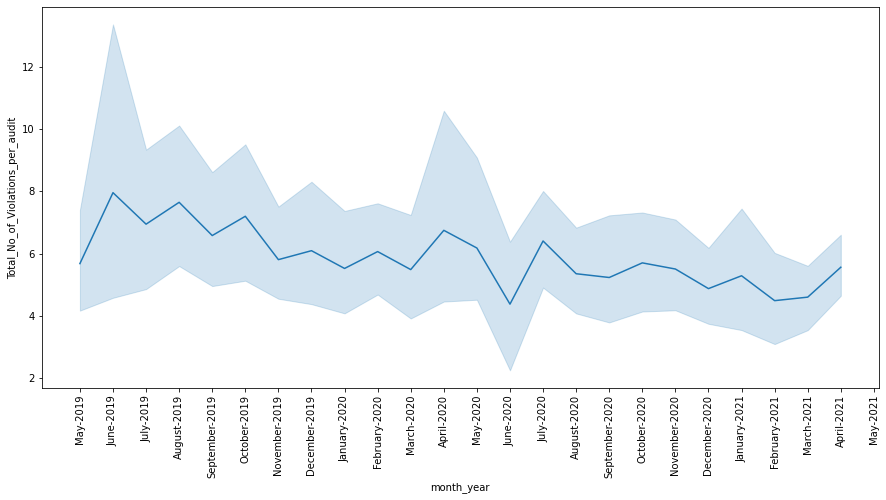

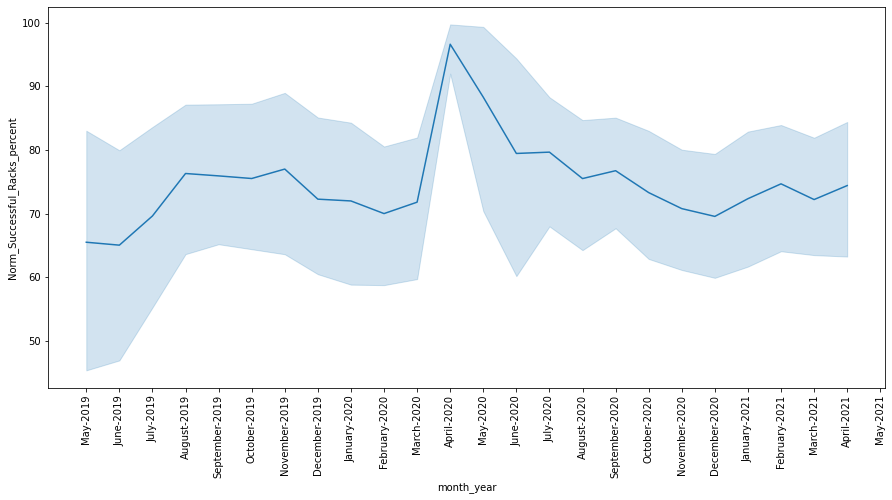

In [15]:
plt.figure(figsize=(15,7))
ax = sns.lineplot(y='Total_No_of_Violations_per_audit', x='month_year', data=df_merged)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15,7))
ax = sns.lineplot(y='Norm_Successful_Racks_percent', x='month_year', data=df_merged)
plt.xticks(rotation=90)
plt.show()

<b>Time period used for analysis is almost 1 years 11 month (23 months) from May 2019 to April 2021 since data was available for this period</b>


# Approach 1: Overall Brand Analysis

## Descriptive Analysis

Key Message-
* Brands with high number of clean dishes (successful rack count percentage) have Lower number of violations

### Clean Dishes & Violations/Audit Distribution acrosss brands 1/3

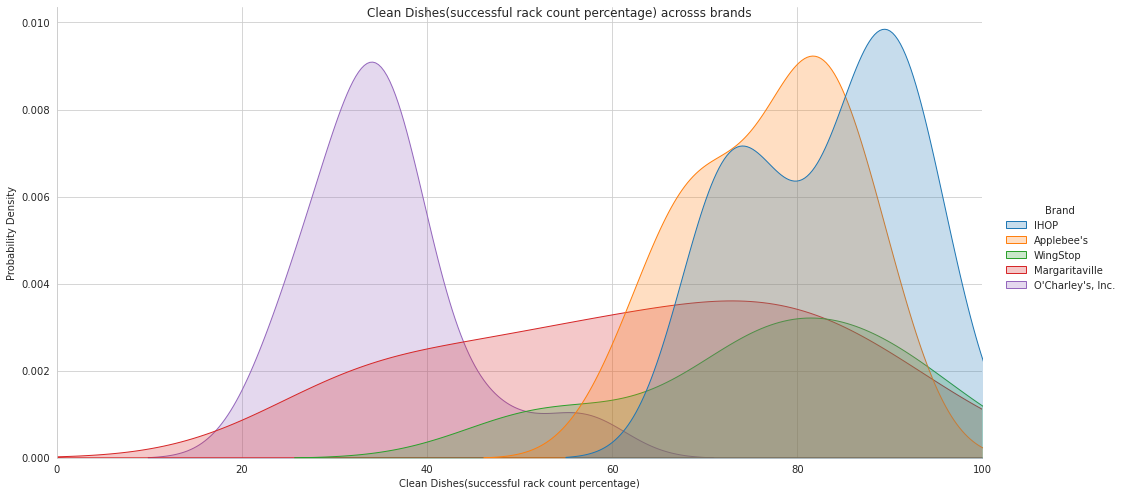

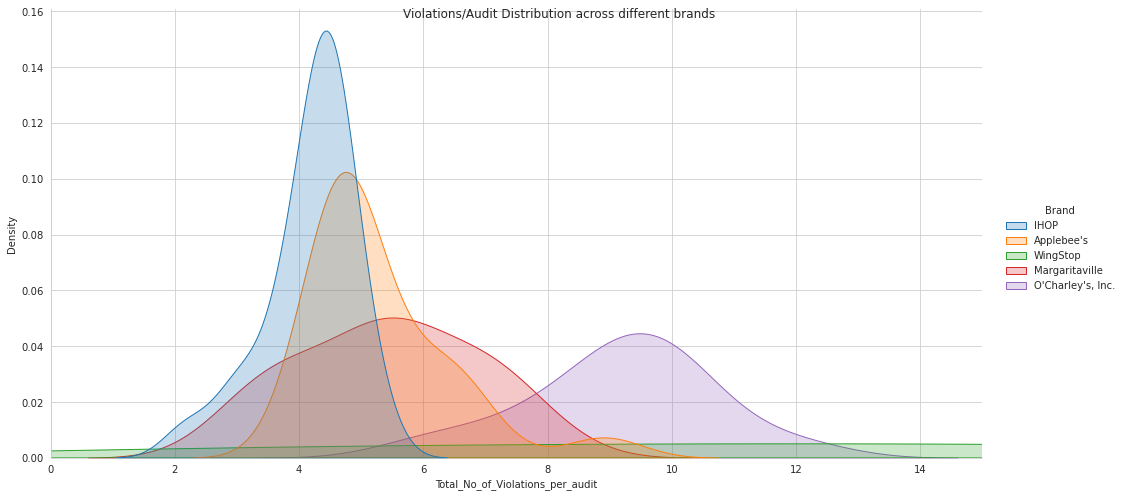

In [16]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(['IHOP', "Applebee's", "O'Charley's, Inc.", 'Margaritaville', 'WingStop'])],
                 x='Successful_Racks_percent', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,100))
ax.set(xlabel = 'Clean Dishes(successful rack count percentage)', ylabel = 'Probability Density')
ax.fig.suptitle("Clean Dishes(successful rack count percentage) acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(['IHOP', "Applebee's", "O'Charley's, Inc.", 'Margaritaville', 'WingStop'])],
                 x='Total_No_of_Violations_per_audit', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,15))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

Finding : 
* For the brand <b>IHOP</b>, the distribution has <b>highest percentage of clean dishes (successful rack counts) and lowest no of violations per audit</b>
* For the brand <b>O'Charleys</b>, the distribution has <b>lowest percentage of clean dishes (successful rack counts) and high no of violations per audit</b>
* For the brand <b>WingStop</b>, the distribution lies between <b> 40 to 80 for clean idshes (successful rack counts) and has the highest no of violations per audit</b>

### Clean Dishes & Violations/Audit Distribution acrosss brands 2/3

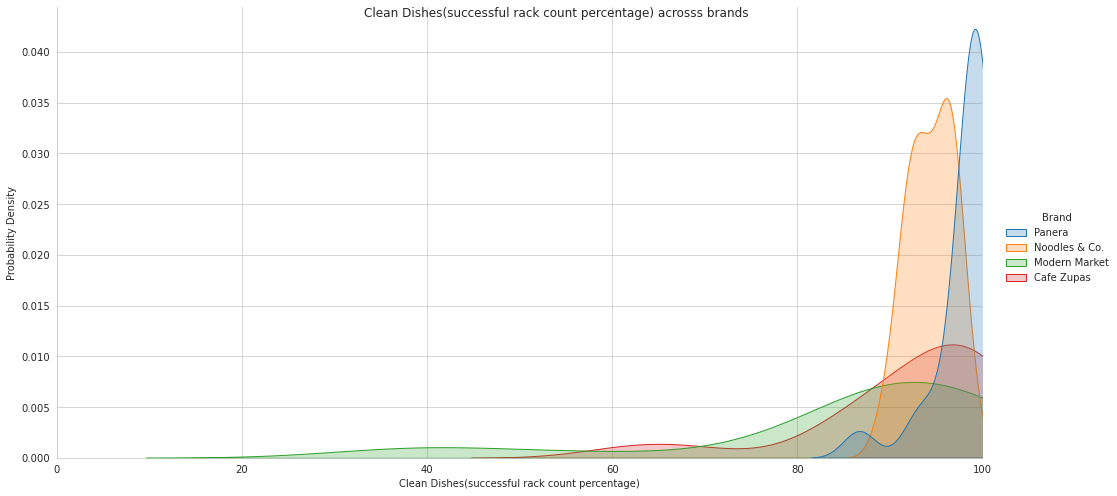

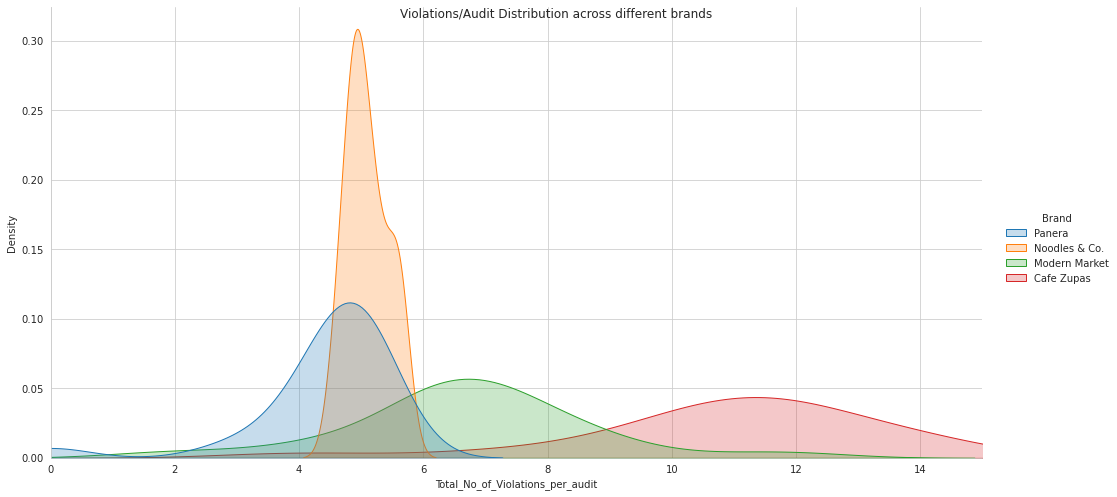

In [17]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Panera", 'Cafe Zupas', 'Noodles & Co.', 'Modern Market'])],
                 x='Successful_Racks_percent', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,100))
ax.set(xlabel = 'Clean Dishes(successful rack count percentage)', ylabel = 'Probability Density')
ax.fig.suptitle("Clean Dishes(successful rack count percentage) acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Panera", 'Cafe Zupas', 'Noodles & Co.', 'Modern Market'])],
                 x='Total_No_of_Violations_per_audit', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,15))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

Findings : 
* For the brands <b>Panera and Noodles & Co </b> the distribution of <b>Clean Dishes(successful rack count percentage) lies between 80  to 100 and have the lowest  # of violations per audit 2 to  6</b>
* For the brand <b> Cafe  Zupas </b> the distribution of <b>Clean Dishes(successful rack count percentage) lies between 60 to 100 and still has very high # of violations per audit between 6 to 14 which is an exception <b>

### Clean Dishes & Violations/Audit Distribution acrosss brands 3/3

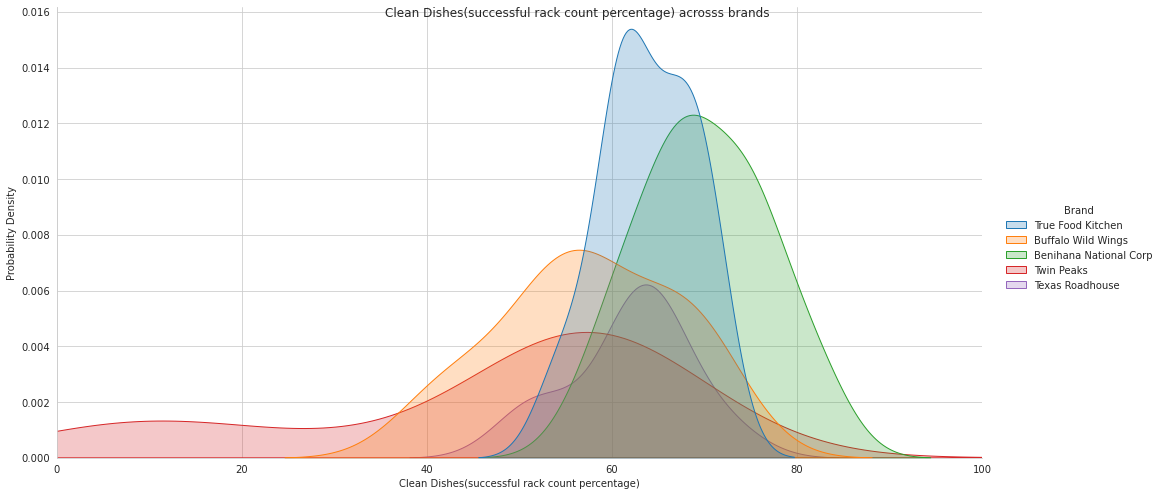

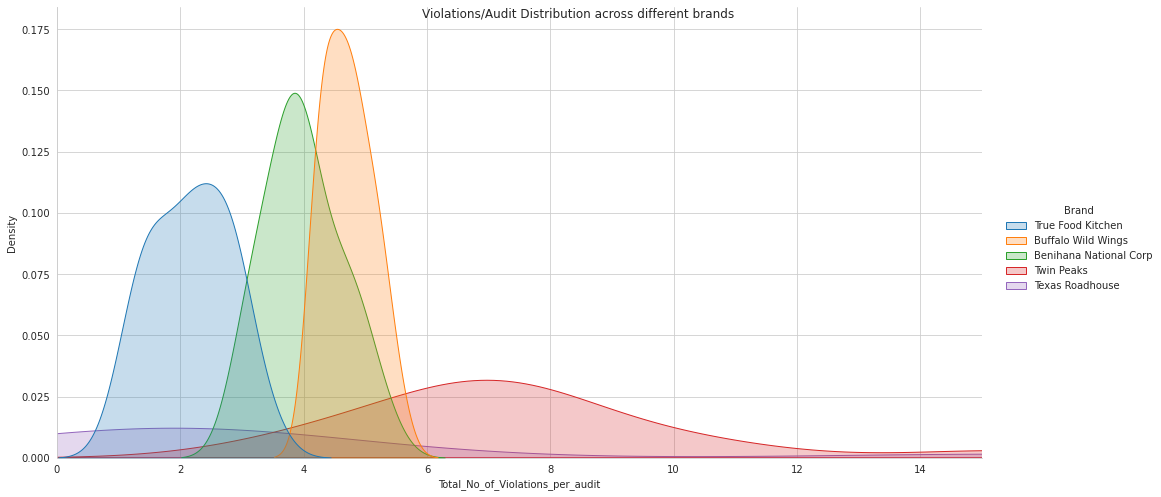

In [18]:
sns.set_style("whitegrid")
ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Twin Peaks", 'True Food Kitchen', 'Texas Roadhouse', 'Benihana National Corp', 'Buffalo Wild Wings'])],
                 x='Successful_Racks_percent', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,100))
ax.set(xlabel = 'Clean Dishes(successful rack count percentage)', ylabel = 'Probability Density')
ax.fig.suptitle("Clean Dishes(successful rack count percentage) acrosss brands",
                  fontsize=12, fontdict={"weight": "bold"})


ax = sns.displot(data=df_merged[df_merged.Brand.isin(["Twin Peaks", 'True Food Kitchen', 'Texas Roadhouse', 'Benihana National Corp', 'Buffalo Wild Wings'])],
                 x='Total_No_of_Violations_per_audit', hue='Brand', kind='kde', fill=True, height=7, aspect=2)
ax.set(xlim=(0,15))
ax.fig.suptitle("Violations/Audit Distribution across different brands",
                  fontsize=12, fontdict={"weight": "bold"})
plt.show()

Findings : 
* For the brands <b> True Food Kitchen, Buffalo Wild Wings, Benihana National Corp, Texas Roadhouse </b> the distribution of Clean Dishes(successful rack count percentage) lies between 30 to 100 and the # of violations per audit seems to be low from 0 to 8
* For the brand <b>Twin Peaks</b> the distribution of <b>Clean Dishes(successful rack count percentage) lies between 0 to 100 and concentrated more on 60 and still has very high # of violations per audit between 2 to 14 which is an exception</b>

## Clean Dishes(succesful rack count percentage across different violation buckets)

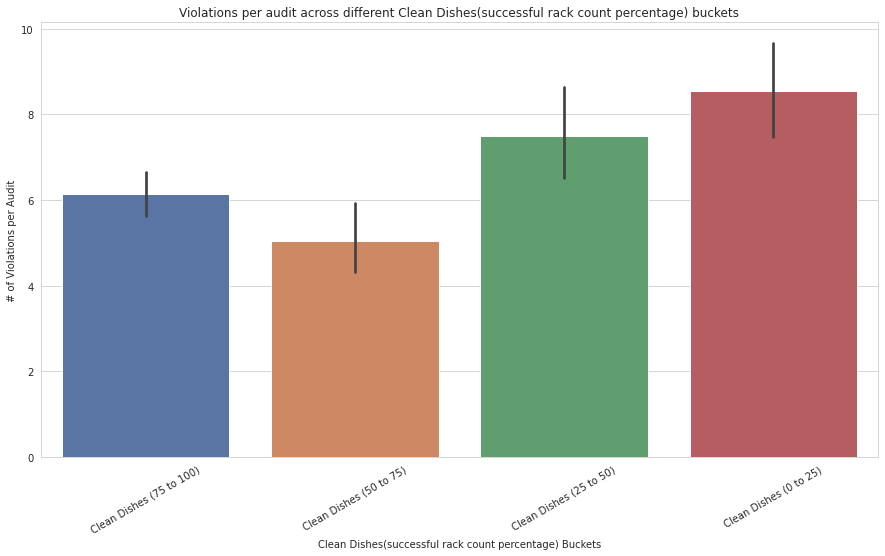

In [19]:
def req_intervals(x):
    bucket = ''
    if (x >= 0) & (x < 25):
        bucket = 'Clean Dishes (0 to 25)'
    elif (x >= 25) & (x < 50):
        bucket = 'Clean Dishes (25 to 50)'
    elif (x >= 50) & (x < 75):
        bucket = 'Clean Dishes (50 to 75)'
    else:
        bucket = 'Clean Dishes (75 to 100)'
        
    return bucket


df_dist_senti = df_merged.copy()
df_dist_senti['Successful_Racks_percent_bucket'] = df_dist_senti['Successful_Racks_percent'].apply(req_intervals)

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Successful_Racks_percent_bucket', y='Total_No_of_Violations_per_audit', data=df_dist_senti, palette = 'deep')
ax.set(xlabel = 'Clean Dishes(successful rack count percentage) Buckets', ylabel = '# of Violations per Audit')
ax.set_title('Violations per audit across different Clean Dishes(successful rack count percentage) buckets')
plt.xticks(rotation=30)
plt.show()

* We see with <b>increase in the Clean Dishes (successful  rack count percentage) the # of Violations per Audit decreses</b>

In [20]:
######################################################## HYPOTHESIS TESTING ###################################################
    
def spearman_corr(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    spearman_corr = []
    null_hypothesis = []
    alternate_hypothsesis = []
    p_val = []
    
    corr, pval = spearmanr(df_datagrouped[test_var],
                            df_datagrouped[measure])
        
    spearman_corr.append(corr)
    p_val.append(pval)
        
    # Accpeted and Rejected interchanged
    if pval < 0.10:
        null_hypothesis.append('Rejected')
        alternate_hypothsesis.append('Accepted')
    else:
        null_hypothesis.append('Accepted')
        alternate_hypothsesis.append('Rejected')

    test_df = pd.DataFrame({'Spearman Coefficient': spearman_corr,
                            'p-value': p_val,
                            'Null Hypothesis': null_hypothesis,
                            'Atlernate Hypothesis': alternate_hypothsesis})
    
    return test_df

def pearsonr_corr_brand(df_datagrouped, test_var, measure):
    '''
    This functions returns a table with spearman hypothesis
    test results
    '''
    from scipy.stats.stats import pearsonr
    brands = list(df_datagrouped.Brand.unique())
    spearman_corr = []
    lengthdata = []
    
    for brand in brands:
        corr,_= pearsonr(np.array(df_datagrouped[df_datagrouped.Brand == brand][test_var]), 
                         np.array(df_datagrouped[df_datagrouped.Brand == brand][measure]))
        lengthdata.append(len(df_datagrouped[df_datagrouped.Brand == brand]))

        spearman_corr.append(corr)
    
    test_df = pd.DataFrame({'Brand': brands,
                            'Data Points': lengthdata,
                            'Correlation Coefficient': spearman_corr
                            })
    # inplace
    test_df.replace(np.nan, 0, inplace=True)
    
    return test_df

######################################################## Correlation Matrix ###########################################################


def correlation_matrix(var, df, title):
    
    # Compute the correlation matrix
    corr_data = df[var]
    sns.set(style="white")
    corr = corr_data.corr()
    corr = corr.round(2)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 10))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 150, n=9)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                annot = True, vmin=-1)

    ax.set_title(title, fontsize=32)
    plt.show()

# Approach 2: Brand Level Analysis

## Correlation Analysis 

Key Message - <br>
* <b>Majority of brands</b> display <b>relationship</b> between our <b>Drivers (i.e. Clean Dishes, Successful Rack count percentage)</b> and <b>Measures (i.e. Violations Per Audit, Audit Score)</b> for the <b>pillar Delighted Guests</b>

### Clean Dishes vs Total No of Violations per Audit

<b>11 out of 14 brands</b> shows <b>negative correlation</b> between Clean Dishes (successful rack count percentage) and total number of violations <br>
<b> i.e. With increase in Clean Dishes (successful rack count percentage), Total number of violations decreases

In [21]:
pearsonr_corr_brand(df_merged, 'Successful_Racks_percent', 'Total_No_of_Violations_per_audit')

,Brand,Data Points,Correlation Coefficient
0,Panera,21,-0.2242
1,True Food Kitchen,21,-0.0691
2,Noodles & Co.,24,-0.1994
3,Modern Market,21,-0.6175
4,IHOP,22,-0.1594
5,Buffalo Wild Wings,19,0.3290
6,Benihana National Corp,23,-0.3003
7,Applebee's,21,0.1834
8,Twin Peaks,17,-0.1826
9,WingStop,11,-0.6505


### Clean Dishes vs Total No of Violations per Audit

<b>6 out of 14 brands</b> shows <b>negative correlation</b> between Clean Dishes (Norm_Successful_Racks) and total number of violations <br>

In [22]:
pearsonr_corr_brand(df_merged, 'Norm_Successful_Racks', 'Total_No_of_Violations_per_audit')

,Brand,Data Points,Correlation Coefficient
0,Panera,21,0.2273
1,True Food Kitchen,21,-0.1136
2,Noodles & Co.,24,-0.0178
3,Modern Market,21,-0.0885
4,IHOP,22,0.2710
5,Buffalo Wild Wings,19,0.1234
6,Benihana National Corp,23,0.2796
7,Applebee's,21,0.0047
8,Twin Peaks,17,0.0668
9,WingStop,11,0.2935


# Approach 3: Across Brands 

Key Messages-
* From Correlation Matrix with Initial Dataset, there is <b>negative correlation between Clean Dishes(successful rack count percentage) & Violations per Audit</b>
* With more <b>Refined Dataset</b>, the <b>correlation</b> becomes <b>more stronger between our Drivers (Clean Dishes(successful rack count percentage)) and Measures of Delighted Guests(Violations per Audit) for Tier 1 outcomes </b>

##  Correlation Matrix

### Data Aggregated at Month-Year & Brand Level

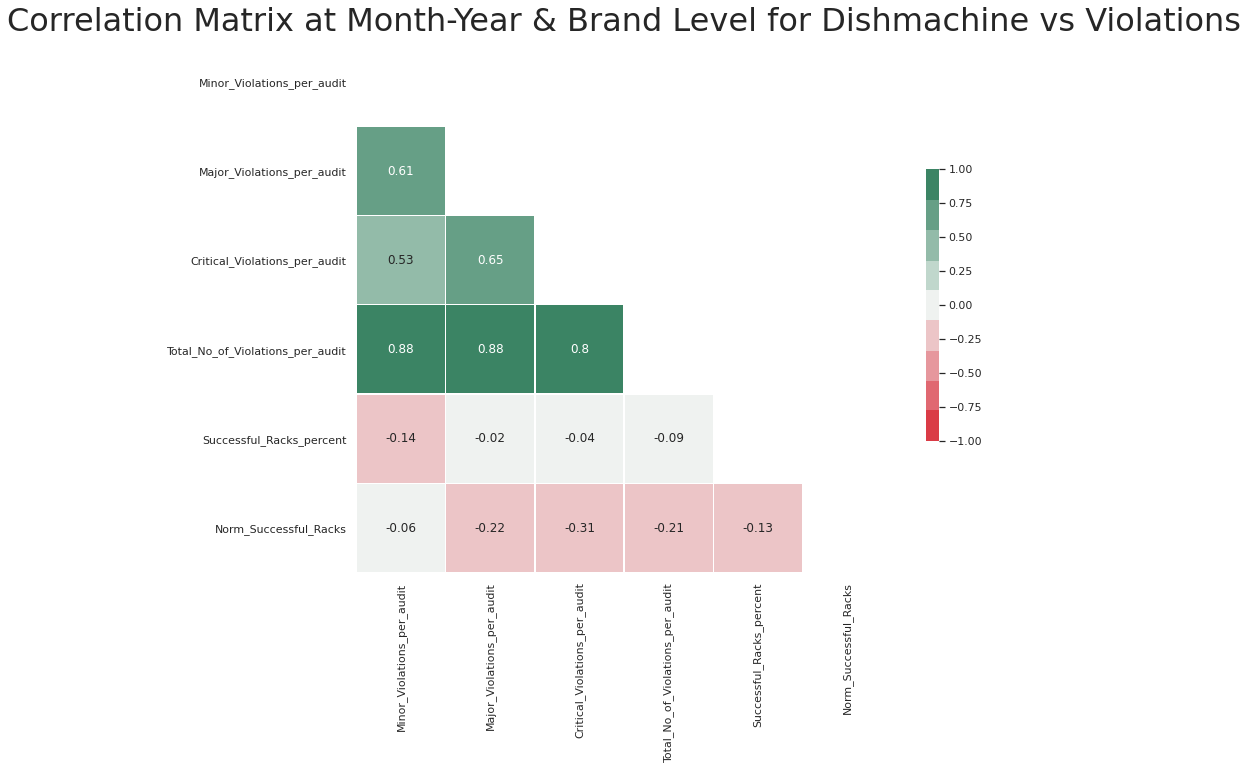

In [23]:
var = ['Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit',
       'Total_No_of_Violations_per_audit', 'Successful_Racks_percent', 'Norm_Successful_Racks']

correlation_matrix(var, df_merged, "Correlation Matrix at Month-Year & Brand Level for Dishmachine vs Violations")

In [24]:
df_merged['Norm_RackCount'].median()

1590.4

In [25]:
df_merged['Audit_per_store'].median()

0.21212121212121213

### Data Aggregated at Month-Year & Brand Level (Refined Data)

Criteria for refining dataset:

* Calculated median for Norm_RackCount and Audit_per_store <br>
* Filtered for data points having Norm_RackCount and Audit_per_store greater than median values i.e Norm_RackCount > 1590.4, Audit_per_store > 0.21

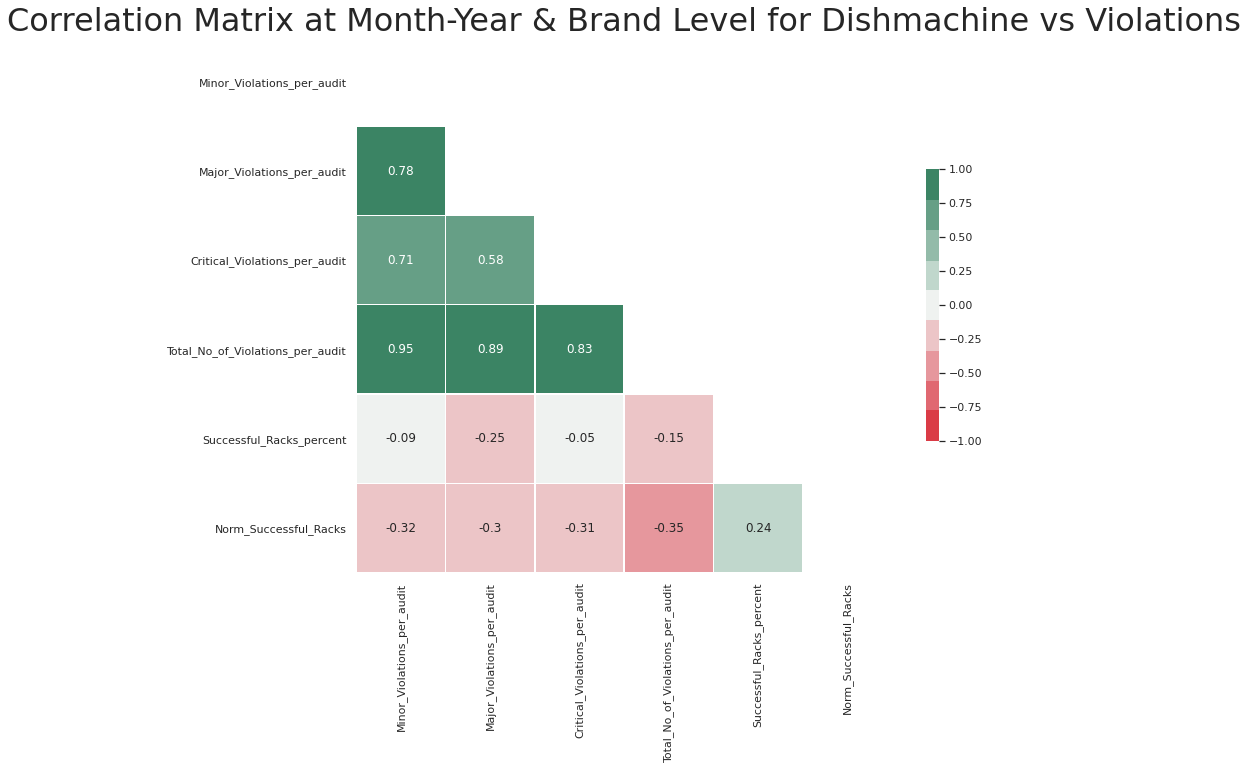

In [26]:
var = ['Minor_Violations_per_audit', 'Major_Violations_per_audit', 'Critical_Violations_per_audit',
       'Total_No_of_Violations_per_audit', 'Successful_Racks_percent', 'Norm_Successful_Racks']

correlation_matrix(var, df_merged[(df_merged['Norm_RackCount'] > df_merged['Norm_RackCount'].median())
                                   & (df_merged['Audit_per_store'] > df_merged['Audit_per_store'].median())],
                   "Correlation Matrix at Month-Year & Brand Level for Dishmachine vs Violations")

## Hypothesis Testing (Refined Data)

Results-
* <b>Increase in Clean Dishes (Successful Rack Count Percentage) does not affect Violations per Audit</b>
* <b>Increase in Clean Dishes (Norm_Successful_Racks), results in decreased Violations per Audit</b>

### Hypothesis 1: Clean Dishes vs Total No of Violations per Audit
<br>
<b>Null Hypothesis:</b> Increase in Clean Dishes (Successful Rack Count Percentage) does not affect Violations per Audit
 
<b>Alternate Hypothesis:</b> Increase in Clean Dishes (Successful Rack Count Percentage), results in decreased Violations per Audit

In [27]:
spearman_corr(df_merged[(df_merged['Norm_RackCount'] > df_merged['Norm_RackCount'].median())
                        & (df_merged['Audit_per_store'] > df_merged['Audit_per_store'].median())],
              'Successful_Racks_percent', 'Total_No_of_Violations_per_audit')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,0.0665,0.5899,Accepted,Rejected


### Hypothesis 2: Clean Dishes vs Total No of Violations per Audit
<br>
<b>Null Hypothesis:</b> Increase in Clean Dishes (Norm_Successful_Racks) does not affect Violations per Audit
 
<b>Alternate Hypothesis:</b> Increase in Clean Dishes (Norm_Successful_Racks), results in decreased Violations per Audit

In [28]:
spearman_corr(df_merged[(df_merged['Norm_RackCount'] > df_merged['Norm_RackCount'].median())
                        & (df_merged['Audit_per_store'] > df_merged['Audit_per_store'].median())],
              'Norm_Successful_Racks', 'Total_No_of_Violations_per_audit')

,Spearman Coefficient,p-value,Null Hypothesis,Atlernate Hypothesis
0,-0.2535,0.0370,Rejected,Accepted


In [29]:
# ########################################################## Reviews Data #################################################################
# #########################################################################################################################################

# # Reading reviews data
# df_panera  = pd.read_csv('./csv/Panera_Bread.csv')
# df_panera = df_panera.loc[:, ~df_panera.columns.str.contains('^Unnamed')]
# df_panera['Brand'] = 'Panera'

# df_ihop  = pd.read_csv('./csv/Ihop.csv')
# df_ihop = df_ihop.loc[:, ~df_ihop.columns.str.contains('^Unnamed')]
# df_ihop['Brand'] = 'IHOP'

# df_buffalow = pd.read_csv('./csv/Buffalow_Wild_Wings.csv')
# df_buffalow = df_buffalow.loc[:, ~df_buffalow.columns.str.contains('^Unnamed')]
# df_buffalow['Brand'] = 'Buffalo Wild Wings'

# df_noodles = pd.read_csv('./csv/Noodles_Company.csv')
# df_noodles = df_noodles.loc[:, ~df_noodles.columns.str.contains('^Unnamed')]
# df_noodles['Brand'] = 'Noodles & Co.'

# df_benihana = pd.read_csv('./csv/Benihana.csv')
# df_benihana = df_benihana.loc[:, ~df_benihana.columns.str.contains('^Unnamed')]
# df_benihana['Brand'] = 'Benihana National Corp'

# df_ontheboard = pd.read_csv('./csv/On_the_Border.csv')
# df_ontheboard = df_ontheboard.loc[:, ~df_ontheboard.columns.str.contains('^Unnamed')]
# df_ontheboard['Brand'] = 'On the Border'

# df_applebees = pd.read_csv('./csv/Applebees.csv')
# df_applebees = df_applebees.loc[:, ~df_applebees.columns.str.contains('^Unnamed')]
# df_applebees['Brand'] = "Applebee's"

# df_friendlys = pd.read_csv('./csv/Friendlys.csv')
# df_friendlys = df_friendlys.loc[:, ~df_friendlys.columns.str.contains('^Unnamed')]
# df_friendlys['Brand'] = "Friendly's"

# df_margaritaville = pd.read_csv('./csv/Margaritaville.csv')
# df_margaritaville = df_margaritaville.loc[:, ~df_margaritaville.columns.str.contains('^Unnamed')]
# df_margaritaville['Brand'] = 'Margaritaville'

# df_rubytuesday = pd.read_csv('./csv/Ruby_Tuesday.csv')
# df_rubytuesday = df_rubytuesday.loc[:, ~df_rubytuesday.columns.str.contains('^Unnamed')]
# df_rubytuesday['Brand'] = 'Ruby Tuesday Inc.'

# df_wingstop = pd.read_csv('./csv/Wing_Stop.csv')
# df_wingstop = df_wingstop.loc[:, ~df_wingstop.columns.str.contains('^Unnamed')]
# df_wingstop['Brand'] = 'Ruby Tuesday Inc.'

# df_modmarket = pd.read_csv('./csv/Modern_Market.csv')
# df_modmarket = df_modmarket.loc[:, ~df_modmarket.columns.str.contains('^Unnamed')]
# df_modmarket['Brand'] = 'Modern Market'

# df_truefood = pd.read_csv('./csv/True_Food.csv')
# df_truefood = df_truefood.loc[:, ~df_truefood.columns.str.contains('^Unnamed')]
# df_truefood['Brand'] = 'True Food Kitchen'

# df_txroadhouse = pd.read_csv('./csv/Texas_Roadhouse.csv')
# df_txroadhouse = df_txroadhouse.loc[:, ~df_txroadhouse.columns.str.contains('^Unnamed')]
# df_txroadhouse['Brand'] = 'Texas Roadhouse'

# df_famousdave = pd.read_csv('./csv/Famous_Dave.csv')
# df_famousdave = df_famousdave.loc[:, ~df_famousdave.columns.str.contains('^Unnamed')]
# df_famousdave['Brand'] = "Famous Dave's of America, Inc."

# df_zupas = pd.read_csv('./csv/Cafe_Zupas.csv')
# df_zupas = df_zupas.loc[:, ~df_zupas.columns.str.contains('^Unnamed')]
# df_zupas['Brand'] = 'Cafe Zupas'

# df_fourcorners = pd.read_csv('./csv/Four_Corners.csv')
# df_fourcorners = df_fourcorners.loc[:, ~df_fourcorners.columns.str.contains('^Unnamed')]
# df_fourcorners['Brand'] = 'Four Corners Tavern Group'

# df_charleys = pd.read_csv('./csv/O_Charleys.csv')
# df_charleys = df_charleys.loc[:, ~df_charleys.columns.str.contains('^Unnamed')]
# df_charleys['Brand'] = "O'Charley's, Inc."

# df_twinpeaks = pd.read_csv('./csv/Twin_Peaks.csv')
# df_twinpeaks = df_twinpeaks.loc[:, ~df_twinpeaks.columns.str.contains('^Unnamed')]
# df_twinpeaks['Brand'] = 'Twin Peaks'

# df_woodranch = pd.read_csv('./csv/Wood_Ranch.csv')
# df_woodranch = df_woodranch.loc[:, ~df_woodranch.columns.str.contains('^Unnamed')]
# df_woodranch['Brand'] = 'Wood Ranch'

# df_review = df_modmarket.append([df_ihop, df_buffalow, df_noodles, df_benihana, df_ontheboard, df_applebees, df_friendlys, 
#                                  df_margaritaville, df_rubytuesday, df_wingstop, df_panera, df_truefood, df_txroadhouse, 
#                                  df_famousdave, df_zupas, df_fourcorners, df_charleys, df_twinpeaks, df_woodranch])

# df_review = df_review[df_review['date'].notnull()]

# # Getting Month-Year from date
# df_review['Date'] = pd.to_datetime(df_review['date'], errors='coerce')
# df_review['Date'] = df_review['Date'].dt.date
# df_review['month_year'] = df_review['Date'].apply(lambda x: x.strftime('%B-%Y'))

# # Flags to be used in aggregation
# df_review['Negative_flag'] = np.where(df_review['Flair_Score'] < 0,1,0)
# df_review['Positive_flag'] = np.where(df_review['Flair_Score'] > 0,1,0)

# df_grouped_review = df_review.groupby(['month_year', 'Brand'], as_index=False).agg({'Flair_Score' : 'mean',
#                                                                                     'Positive_flag' : 'sum',
#                                                                                     'Negative_flag' : 'sum',
#                                                                                     'rating' : 'mean',
#                                                                                     'text' : 'count'})
# df_grouped_review.rename({'text' : 'No_of_Reviews',
#                           'rating' : 'Rating',
#                           'Positive_flag': 'Positive_Reviews',
#                           'Negative_flag': 'Negative_Reviews'}, axis=1, inplace=True)

# # Calculating KPIs
# df_grouped_review['Positive_Review_Percent'] = (df_grouped_review['Positive_Reviews']/df_grouped_review['No_of_Reviews'])*100
# df_grouped_review['Negative_Review_Percent'] = (df_grouped_review['Negative_Reviews']/df_grouped_review['No_of_Reviews'])*100

In [30]:
# df_merged_reviews = pd.merge(df_dish_agg, df_grouped_review, how='left', on=['month_year', 'Brand'])
# df_merged_reviews.dropna(how='all', inplace=True)

# var = ['Flair_Score',
#        'Rating', 'Norm_RackCount_wo_alarm_percent', 'Norm_RackCount_wo_alarm']

# correlation_matrix(var, df_merged_reviews, "Correlation Matrix at Month-Year & Brand Level for Dishmachine vs Sentiment")